<a href="https://colab.research.google.com/github/songmac/2023-Sesac-Lecture-and-Project/blob/master/231019~20_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D_%EC%98%81%ED%99%94%EA%B0%90%EC%83%81%EB%A6%AC%EB%B7%B0(%EB%82%98%EC%9D%B4%EB%B8%8C%EB%B2%A0%EC%9D%B4%EC%A7%80%2C_RNN)%EC%8B%A4%EC%8A%B5(solving).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습 1.Naive Bayes 감정분석
- happy , weekend 단어가 포함된 문장이 긍정일확률과 부정일확률

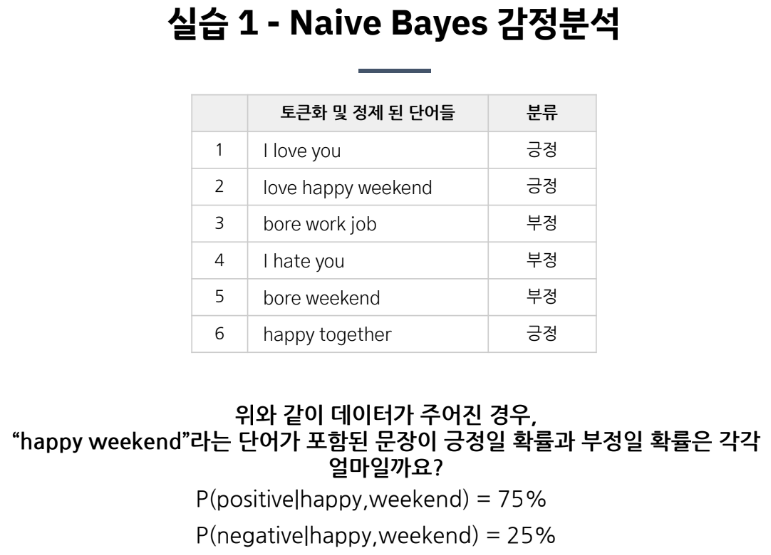

In [ ]:
text = [("I love you", "P"),
        ("love happy weekend", "P"),
        ("bore work job", "N"),
        ("I hate you", "N"),
        ("bore weekend", "N"),
        ("happy together", "P")]

word = ["happy weekend"]

In [ ]:
X_train = [t[0] for t in text]
Y_train = [t[1] for t in text]
X_train

['I love you',
 'love happy weekend',
 'bore work job',
 'I hate you',
 'bore weekend',
 'happy together']

In [ ]:
Y_train

['P', 'P', 'N', 'N', 'N', 'P']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer() #Count vectorizer 선언
X_train_counts = count_vect.fit_transform(X_train) #자동으로 공백으로 토큰화
model = MultinomialNB() #MultinomialNB 선언
model.fit(X_train_counts, Y_train)

MultinomialNB()

In [ ]:
# label 예측
model.predict(count_vect.transform(["happy weekend"]))

array(['P'], dtype='<U1')

In [ ]:
# label 예측의 확률 값
model.predict_proba(count_vect.transform(["happy weekend"]))

array([[0.25, 0.75]])

# 실습 2. 새로운 문장 집어 넣어서 긍정인지 부정인지 예측

- 영화 데이터 불러오기
- 데이터 전처리하기(불용어 제거, 토큰화)
- 나이브 베이즈 감정분석 모델(RNN) 만들기
- acc, f1-score을 출력하기
- "올해 본 영화 중 가장 최고야" 넣었을 때 긍정인지 부정인지 예측하기

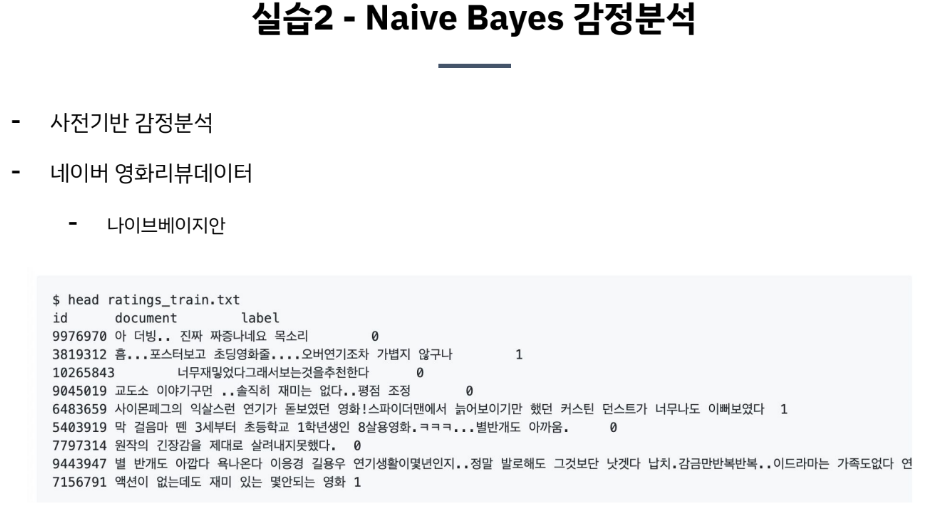

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/실습/data/review.csv', delimiter='\t')
# print(df)

In [ ]:
df = df[:100] #(id, document, label column) 있음
df

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
95,8763660,어내스트와 셀레스틴 완전 강추에요~ 정말 재밌습니다^^,1
96,9361974,재미있는영화입니다.,1
97,7928957,클라라볼라고화신본거아닌데,0
98,10250221,진짜 보면서 너무 슬펐던 영화다,1


# Part1. 데이터 전처리

In [ ]:
! pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 49.0 MB/s eta 0:00:00


In [ ]:
#리뷰 내용 첫번째 줄 확인
sample_text = df['document'].iloc[0]
print(type(sample_text))
print(sample_text)

<class 'str'>
아 더빙.. 진짜 짜증나네요 목소리


In [ ]:
#한국어 분석 라이브러리 호출
from konlpy.utils import pprint
from konlpy.tag import Okt

okt = Okt()
print(okt)

In [ ]:
#pos 로 품사 태깅
tokens = okt.pos(sample_text)
pprint(tokens)

[('아', 'Exclamation'),
 ('더빙', 'Noun'),
 ('..', 'Punctuation'),
 ('진짜', 'Noun'),
 ('짜증나네요', 'Adjective'),
 ('목소리', 'Noun')]


In [ ]:
#morphs 로 모든 형태소 반환, nouns 로 명사만 반환
tokens = okt.morphs(sample_text)
pprint(tokens)

['아', '더빙', '..', '진짜', '짜증나네요', '목소리']


In [ ]:
tokens = okt.nouns(sample_text)
pprint(tokens)

['더빙', '진짜', '목소리']


In [ ]:
#결측지 있다면 제거
review_data = df['document'].dropna().values

#review_data 1줄만 확인
print(review_data.shape)
print(review_data[0],'\n')

(100,)
아 더빙.. 진짜 짜증나네요 목소리 



In [ ]:
# 모든 리뷰의 1글자 이상 명사 추출하기
cleaned_review_data = []

for review in (review_data):
  tokens = okt.nouns(review)
  cleaned_tokens = []

  for word in tokens:
    if len(word) > 1:
      cleaned_tokens.append(word)
    else:
      pass
  cleaned_review = " ".join(cleaned_tokens)
  cleaned_review_data.append(cleaned_review)

print(len(cleaned_review_data))
print(cleaned_review_data)

100
['더빙 진짜 목소리', '포스터 보고 초딩 영화 오버 연기', '무재 밓었 다그 래서 추천', '교도소 이야기 구먼 재미 평점 조정', '몬페 연기 영화 스파이더맨 커스틴 던스트', '걸음 초등학교 학년 생인 영화 반개', '원작 긴장감 제대로', '반개 이응경 길용우 생활 정말 해도 그것 납치 감금 반복 반복 드라마 가족 연기 사람', '액션 재미 영화', '왜케 평점 헐리우드', '인피니트 진짜', '볼때 향수 자극 허진호 감성 절제 멜로 달인', '울면 횡단보도 이범수 연기', '로만 자꾸 사람', '취향 존중 다지 진짜 내생 극장 영화 가장 노잼 감동 스토리 어거지 감동 어거지', '매번 긴장 재밋음', '사람 바스코 이기 락스 바비 이기 아이돌 그냥 안달', '굿바이 레닌 표절 이해 갈수록 재미', '이건 정말 깨알 캐스팅 질퍽 용구성 버무러진 깨알 일드', '약탈 변명 절대', '나름 그냥 학생 선생 영화 절대', '', '음식 영화 바베트 만찬 바베트 만찬 이야기 음식 재미 이건 음식 별로 핀란드 풍경 할랫 그것 별로', '절대 영화 수작 는걸', '주제 중반', '짤랐을꺼 납득', '고추', '카밀라 발연기', '재밋는뎅', '센스 연출 캐스팅 향수', '엄포스 위력 다시 한번 검사 연기 정말 완전 명품 드라마', '쓰레기 도안 시간', '', '죄인 죄인', '드라마 인생 최고', '패션 대한 열정 안나 투어', '키이라 나이틀리 연기 대체 정신장애 틱장애', '원작 정신 유령', '포스터 관객', '영화 평가', '매력 영화', '알바생 내용 하나 완전 영화 시간 완전 낚임', '서리', '정말 방법', '윤제문 배우 발견 미소 머금 음악 조금 평점', '평점 속지 시간 낭비 낭비', '리얼리티 공감 간다 이민기 캐릭터 정신의학 분노조절 장애 초기 증상 툭하면 사람 물건 파손 조금 초반 가면 갈수록 이민기 정신 상태 공감 불가', '마이너스 뮤비 보고 영화 수준 북한', '우리 영화 사랑', '리스 타르 용의 주인 근친상간 소설 제일

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, Y_train, Y_test = train_test_split(
    cleaned_review_data,  # X_train, X_test 로 추출
    df['label'],          # Y_train, Y_test 로 추출
    test_size    = 0.33,
    random_state = 42 )

count_vect = CountVectorizer() #Count vectorizer 선언
X_train_counts = count_vect.fit_transform(X_train) #자동으로 공백으로 토큰화

tfidf_trans = TfidfTransformer() # TfidVectorizer 선언 #중요도 학습
X_train_tfidf = tfidf_trans.fit_transform(X_train_counts)

model = MultinomialNB() #MultinomialNB 선언
model.fit(X_train_tfidf, Y_train)

MultinomialNB()

In [ ]:
y_prediction = model.predict(count_vect.transform(X_test))
y_prediction

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [ ]:
# 위 내용을 한꺼번에 실행해본다
from sklearn.metrics import classification_report
report = classification_report(Y_test, y_prediction, target_names =['부정(0)', '긍정(1)'])
print(report)

              precision    recall  f1-score   support

       부정(0)       0.43      0.20      0.27        15
       긍정(1)       0.54      0.78      0.64        18

    accuracy                           0.52        33
   macro avg       0.48      0.49      0.45        33
weighted avg       0.49      0.52      0.47        33



In [ ]:
# label 예측
test = '"올해 본 영화 중 가장 최고야"'

model.predict(count_vect.transform([test]))

array([1])

In [ ]:
# label 예측의 확률 값
model.predict_proba(count_vect.transform([test]))

array([[0.46732067, 0.53267933]])

# 실습 3. RNN 모형으로 영화 감상 리뷰 긍정, 부정 예측
- X, Y input
- X 의 unique 한 토큰들의 dictionary 목록 생성
- 숫자가 아닌 값 인코딩
- X 리스트(문장)의 길이를 동일하게 패딩(zeros) : 평균 길이를 구해서 적당한 값을 골라 잘라주거나 채워줌



In [ ]:
import numpy as np
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer # 토큰화
from tensorflow.keras.preprocessing.sequence import pad_sequences # 케라스 전처리 도구 for 패딩
from tensorflow.keras.models import Sequential # 레이어(층) 연결
from tensorflow.keras.layers import Dense,Flatten,Embedding # 레이어 설정, 1차원화, word2vect
from tensorflow.keras.optimizers.legacy import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/실습/data/review.csv', delimiter='\t')

Mounted at /content/drive


In [ ]:
import re

# '한글'을 제외한 다른 문자 모두 제거
remove_except_ko = re.compile(r"^가-힣ㄱ-ㅎㅏ-ㅣ\\s")
def preprocess_remove(text):
  text = re.sub(remove_except_ko,' ',text).strip()
  return text

df['document'] = df['document'].map(lambda x : preprocess_remove(x))

In [ ]:
# 텍스트 리뷰 정의
docs = df['document'].to_list()

In [ ]:
len(docs)

10000

In [ ]:
# 긍정 리뷰는 1, 부정 리뷰는 0으로 클래스 지정
classes = df['label']

In [ ]:
len(classes)

10000

In [ ]:
# from tensorflow.keras.preprocessing.text import Tokenizer

# token = Tokenizer()
# token.fit_on_texts(docs) # 문장에 토큰화 적용
# print(token.word_counts) # 단어별 빈도수 확인 (결과창 길어서 생략)

In [ ]:
# # 인덱스 길이, 각 단어 인덱스 값 확인
# print(len(token.word_index))
# print(token.word_index) # 2회 나온 글쎄요 1번 인덱스, 나머지는 순서대로

In [ ]:
# # 문장 별 토큰화 결과 확인
# x = token.texts_to_sequences(docs)
# print('불용어처리 텍스트, 토큰화 결과: \n', x)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(docs, classes, random_state = 0)

In [ ]:
# test_docs = ["영화 재밌네요","올해 영화 중 최고예요","참 잘 만든 영화예요","추천하고 싶지 않은 영화입니다","두번 더 보고싶네요","글쎄요","아주 별로예요","생각보다 재미없네요","배우 연기가 어색해요","글쎄요 재미없어요"]
# classes_test = array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
# 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer
token_text = Tokenizer()
token_text.fit_on_texts(X_train)

# 문장 별 토큰화 결과 확인
test_token_text = token_text.texts_to_sequences(X_train)
print("\n훈련 텍스트, 토큰화 결과:\n",  test_token_text)


훈련 텍스트, 토큰화 결과:
 [[5840, 5841], [5842, 1600, 5843, 5844, 5845, 5846, 3109, 224, 69, 1045, 3, 5847, 72], [5848, 63, 1046, 5849, 3110, 5850, 3111, 284, 192, 13, 1290, 1], [753, 239, 1, 5851, 2143], [313, 5852, 5853, 50], [53, 61], [2, 5854, 107, 1, 213], [147, 5855, 3112, 214, 3113, 121, 34, 54, 40, 5856], [2144, 5857, 5858, 5859, 5860, 5861], [5862, 1291, 5863, 5864], [5865, 5866, 3114, 1292, 1, 5867, 1601], [62, 30, 2145, 2146, 5868], [2147, 314], [3115, 2148, 488, 302, 754], [2149, 5869, 865, 369, 3116], [5870], [2, 5871], [489, 5872, 3117, 5873, 5874, 5875, 5876, 5877, 5878, 5879, 5880, 5881, 5882, 5883, 5884, 5885, 64, 5886, 3118, 5887, 1047, 5888, 5889, 1048, 5890, 5891, 5892, 5893], [3119, 755, 3120, 5894], [5895, 23, 370, 3121, 5896, 31, 108, 3122, 756, 3123, 5897, 5898, 178, 5899, 5900, 5901, 76, 1], [1602, 1603], [5902, 5903, 2150, 1049, 1604, 5904], [3124, 255, 5905, 1, 27, 340, 435, 5906, 26], [436, 1050, 5907, 1050, 54, 54, 54, 225], [8, 3125, 371, 5908, 757, 256, 1605, 80,

In [ ]:
print(len(token_text.word_index))
token_text.word_index

28907


{'영화': 1,
 '정말': 2,
 '너무': 3,
 '진짜': 4,
 '이': 5,
 '그냥': 6,
 '이런': 7,
 '왜': 8,
 '영화를': 9,
 '더': 10,
 '보고': 11,
 '다': 12,
 '잘': 13,
 '그': 14,
 'ㅋㅋ': 15,
 '수': 16,
 '본': 17,
 '좀': 18,
 '이거': 19,
 '영화가': 20,
 '이렇게': 21,
 '영화는': 22,
 '최고의': 23,
 '아': 24,
 '이건': 25,
 '없다': 26,
 '역시': 27,
 '있는': 28,
 '연기': 29,
 '평점': 30,
 '없는': 31,
 '참': 32,
 '드라마': 33,
 '봤는데': 34,
 '내가': 35,
 '최고': 36,
 '평점이': 37,
 '완전': 38,
 '그리고': 39,
 '다시': 40,
 '이게': 41,
 '한': 42,
 '하는': 43,
 '보는': 44,
 '스토리': 45,
 '내': 46,
 '없고': 47,
 'ㅋ': 48,
 '난': 49,
 'ㅠㅠ': 50,
 '것': 51,
 '또': 52,
 '쓰레기': 53,
 '꼭': 54,
 '아깝다': 55,
 '좋은': 56,
 '많이': 57,
 '가장': 58,
 'ㅡㅡ': 59,
 'ㅋㅋㅋ': 60,
 '10점': 61,
 '솔직히': 62,
 '보면': 63,
 '뭐': 64,
 '재밌게': 65,
 '영화다': 66,
 '대한': 67,
 '봐도': 68,
 '하지만': 69,
 '마지막': 70,
 '전혀': 71,
 'ㅎㅎ': 72,
 '별': 73,
 '재밌다': 74,
 '작품': 75,
 '같은': 76,
 '영화의': 77,
 '무슨': 78,
 '같다': 79,
 '감독의': 80,
 '근데': 81,
 '하고': 82,
 '별로': 83,
 '끝까지': 84,
 '와': 85,
 '내내': 86,
 '넘': 87,
 '아주': 88,
 '내용도': 89,
 '볼': 90,
 '아직도': 91,
 'ㅠ': 

In [ ]:
X_train[:2]

['존경하시는 분이에요 ,.',
 '음악영화라 나에겐 취향저격이지만... 비긴어게인처럼 대중적으로 흥행하긴 힘들 영화네요.. 하지만 여주가 너무 매력적이에요 ㅎㅎ']

In [ ]:
X_train_array_list = token_text.texts_to_sequences(X_train)
X_test_array_list = token_text.texts_to_sequences(X_test)

Y_train = np.array(y_train)
Y_test = np.array(y_test)
print('훈련데이터 X: ', len(X_train_array_list))
print('훈련데이터 Y: ', len(Y_train))

훈련데이터 X:  7500
훈련데이터 Y:  7500


In [ ]:
print(X_train[:2])
print(X_train_array_list[:2])

['존경하시는 분이에요 ,.', '음악영화라 나에겐 취향저격이지만... 비긴어게인처럼 대중적으로 흥행하긴 힘들 영화네요.. 하지만 여주가 너무 매력적이에요 ㅎㅎ']
[[5840, 5841], [5842, 1600, 5843, 5844, 5845, 5846, 3109, 224, 69, 1045, 3, 5847, 72]]


리뷰의 최대 길이 : 144
리뷰의 평균 길이 : 35.63693333333333


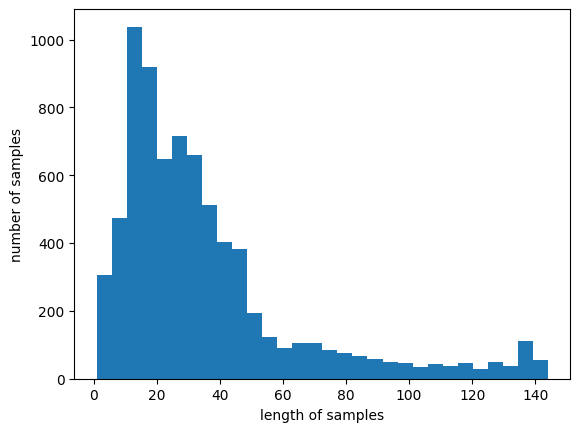

In [ ]:
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(s) for s in X_train], bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
X_train = X_train_array_list
X_test = X_test_array_list

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 35
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       5840, 5841], dtype=int32)

# Part2. 모델링

In [ ]:
# 모델 적용 (입력층, 은닉층, 출력층 연결)
model = Sequential()

# 임베딩 (텍스트를 벡터화 )
# 벡터화 -> 크기조절이 가능한 배열구조로 구현
model.add(Embedding(26, 10, input_length=40))
model.add(Flatten()) # 다차원인 텐서플로 평탄화
model.add(Dense(128, activation='relu'))  # 이진 분류(긍정/부정)
model.add(Dense(64, activation='relu'))  # 이진 분류(긍정/부정)
model.add(Dense(32, activation='relu'))  # 이진 분류(긍정/부정)
model.add(Dense(1, activation='sigmoid'))  # 이진 분류(긍정/부정)

# 모델 컴파일 (활성화함수 adam 적용, 오차함수 이항교차엔트로피)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# 모델 학습 : 데이터로 패딩된 피처(padded_tokt)와 클래스를 넣어준다.
model.fit(padded_tokt, classes, epochs=20) # 결과 생략

ValueError: ignored

# 실습 4. TF-IDF로 영화감상 리뷰 키워드 뽑기